# 🌤️ Weather Prediction Project — Forecasting Next-Day Maximum Temperature in San Antonio, Texas

**Author:** Qian Li  

**Email:** lenia17.lq@gmail.com

---

## 📘 Project Overview
This notebook develops a **machine learning pipeline** to forecast the **next day’s maximum temperature (`TMAX`)** in **OAKLAND INTERNATIONAL AIRPORT, CA US**, based on historical local weather data from the dataset **`local_weather.csv`**. 

The goal is to build a well-structured, explainable, and reproducible workflow, from data loading to model evaluation that can serve as a foundation for broader weather prediction tasks.

---

## 🎯 Objectives
- **Target definition:** `TMAX_next_day = TMAX.shift(-1)` (align features at day *t* with TMAX at day *t+1*).  
- **Model:** **Ridge Regression** (`sklearn.linear_model.Ridge`) as a strong, regularized linear baseline.  
- **Validation:** **Time-aware** split (chronological) to prevent leakage.  
- **Metrics:** **MAE**, **RMSE**, **R²** for clear, interpretable evaluation.

## 🔍 Notebook Roadmap
1. Data loading & inspection
2. Cleaning & preprocessing
3. Exploratory Data Analysis
4. Model Building
5. Model Evaluation
6. Enrichment
7. Conclusion

In [53]:
# --- Import required libs ---

# Foundation
import pandas as pd
import numpy as np
import warnings, joblib

# Visualization
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & processing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# --- Configuration ---

# Silence non-critical warnings
warnings.filterwarnings("ignore")

# Wider DataFrame display for easier inspection
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Visualization defaults
sns.set_theme(style="whitegrid", palette="icefire")
plt.rcParams["figure.figsize"] = (8, 5)

### 1️⃣ Data Loading & Inspection

##### Data Loading

In [3]:
# Read data
df = pd.read_csv("local_weather.csv", index_col="DATE")

##### Data Inspection

In [4]:
# Check the shape and preview of the dataset
print(f"Shape: {df.shape}")
df.head()

Shape: (16859, 35)


,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF1,WDF2,WDF5,WDFG,WSF1,WSF2,WSF5,WSFG,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,49.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,49.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1960-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,54.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,54.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,55.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [5]:
# Calculate the percentage of missing values for each column
missing_pct = df.isna().mean() * 100
no_missing = missing_pct[missing_pct == 0]
moderate_missing = missing_pct[(missing_pct > 0) & (missing_pct <= 65)]
high_missing = missing_pct[missing_pct > 65]

print("No missing values:\n", no_missing.index.tolist())
print("\nModerate missing values (under 65%):\n", moderate_missing.index.tolist())
print("\nHigh missing values (above 65%):\n", high_missing.index.tolist())

No missing values:
 ['STATION', 'NAME']

Moderate missing values (under 65%):
 ['AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']

High missing values (above 65%):
 ['ACMH', 'ACSH', 'DAPR', 'FMTM', 'FRGT', 'MDPR', 'TAVG', 'TSUN', 'WDF1', 'WDFG', 'WSF1', 'WSFG', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT07', 'WT08', 'WT09', 'WT16', 'WT18']


##### 🧩 Observation — Missing Value Categorization

The dataset contains **16,859 rows** and **35 columns**, representing daily weather records from a single station, OAKLAND INTERNATIONAL AIRPORT, CA US, starting from 1960. After calculating and categorizing the missing value percentages for each variable, it is observed that the dataset exhibits clear differences in data completeness across variables.

- **No missing values** include only the columns STATION and NAME are fully populated, representing metadata about the weather station.
- **Moderate missing values (under 65%)** include TMAX, TMIN, PRCP, SNOW, SNWD, and several wind-related variables. These variables have relatively low to moderate levels of missingness and therefore can be considered for further analysis.
- **High missing values (above 65%)** are observed in variables such as ACMH, ACSH, DAPR, FRGT, MDPR, TAVG, TSUN, and multiple WT** codes, indicating limited or inconsistent data recording for these features.

Overall, this step provides a clearer understanding of data quality. The next step will focus on identifying core variables from the no-missing and moderately missing groups, prioritizing those with the lowest missing rates and strongest meteorological relevance. 

In [6]:
# Sort moderate missing variables by missing percentage in ascending order
moderate_missing_sorted = moderate_missing.sort_values(ascending=True)

# Display results
print(moderate_missing_sorted)

TMAX     0.053384
TMIN     0.059315
PRCP     1.666766
SNWD    31.763450
SNOW    32.498962
PGTM    49.510647
WSF2    52.233229
WDF2    52.239160
AWND    52.245092
WDF5    52.755205
WSF5    52.755205
dtype: float64


##### 🧩 Observation — Core Feature Selection

After sorting the moderately missing variables by their percentage of missing values, the five variables with the lowest missing rates are TMAX, TMIN, PRCP, SNOW, and SNWD. These were selected as the core features for further analysis.

- **TMAX** and **TMIN** represent the **daily maximum and minimum temperatures**, which are fundamental indicators for understanding climate patterns and long-term temperature trends.
- **PRCP (precipitation)** reflects the **daily rainfall amount**, providing essential information for hydrological and climate variability studies.
- **SNOW** and **SNWD** measure **snowfall** and **snow depth**, which are key variables for understanding winter weather dynamics and local water resources.

These features were chosen because:
1. they have **high data completeness**.
2. they are **meteorologically meaningful**.
3. thet collectively capture the **core dimensions of weather**.

Other variables such as wind direction or sunshine duration have much higher missingness and may be less reliable or not consistently measured throughout the dataset. Therefore, they are excluded from the primary analysis.

In [7]:
# Core columns for our weather prediction
data = df[['PRCP','SNOW','SNWD','TMAX','TMIN']].copy()

Based on the identified core variables, the dataset is now refined to include only 5 core weather features, and the column names are renamed for clarity.

In [8]:
# Renaming columns
data.columns=['precipitation','snow','snow_depth','temp_max',"temp_min"]
data.head()

,precipitation,snow,snow_depth,temp_max,temp_min
DATE,,,,,
1960-01-01,0.0,0.0,0.0,49.0,30.0
1960-01-02,0.0,0.0,0.0,49.0,29.0
1960-01-03,0.0,0.0,0.0,54.0,35.0
1960-01-04,0.0,0.0,0.0,54.0,36.0
1960-01-05,0.0,0.0,0.0,55.0,33.0


### 2️⃣ Cleaning & Preprocessing

##### Handling Missing Values

In [9]:
# Percentage of missing values for core features
data.isna().mean() * 100

precipitation     1.666766
snow             32.498962
snow_depth       31.763450
temp_max          0.053384
temp_min          0.059315
dtype: float64

##### 🧩 Observation — Core Feature Completeness

The `snow` and `snow_depth` columns have the **highest proportions of missing values (around 32%)**, while `precipitation`, `temp_max`, and `temp_min` are **nearly complete**. This indicates that temperature and precipitation data are well recorded and reliable for analysis, whereas the snow-related features require closer examination.

To better understand the nature of the missingness, a more detailed inspection will be conducted on the `snow` and `snow_depth` variables, examining how their missing values are distributed across time and whether they reflect true zero-snow events or data recording gaps. The findings from this step will guide whether these variables should be retained, imputed, or removed in the preprocessing phase.

In [10]:
# Quick check of value counts
snow_cols = ['snow', 'snow_depth']

vc = data[snow_cols].apply(lambda s: s.value_counts(dropna=False))
print("Value counts (including NaN):\n", vc.fillna(0).astype(int).to_string())

Value counts (including NaN):
       snow  snow_depth
0.0  11379       11504
1.0      1           0
NaN   5479        5355


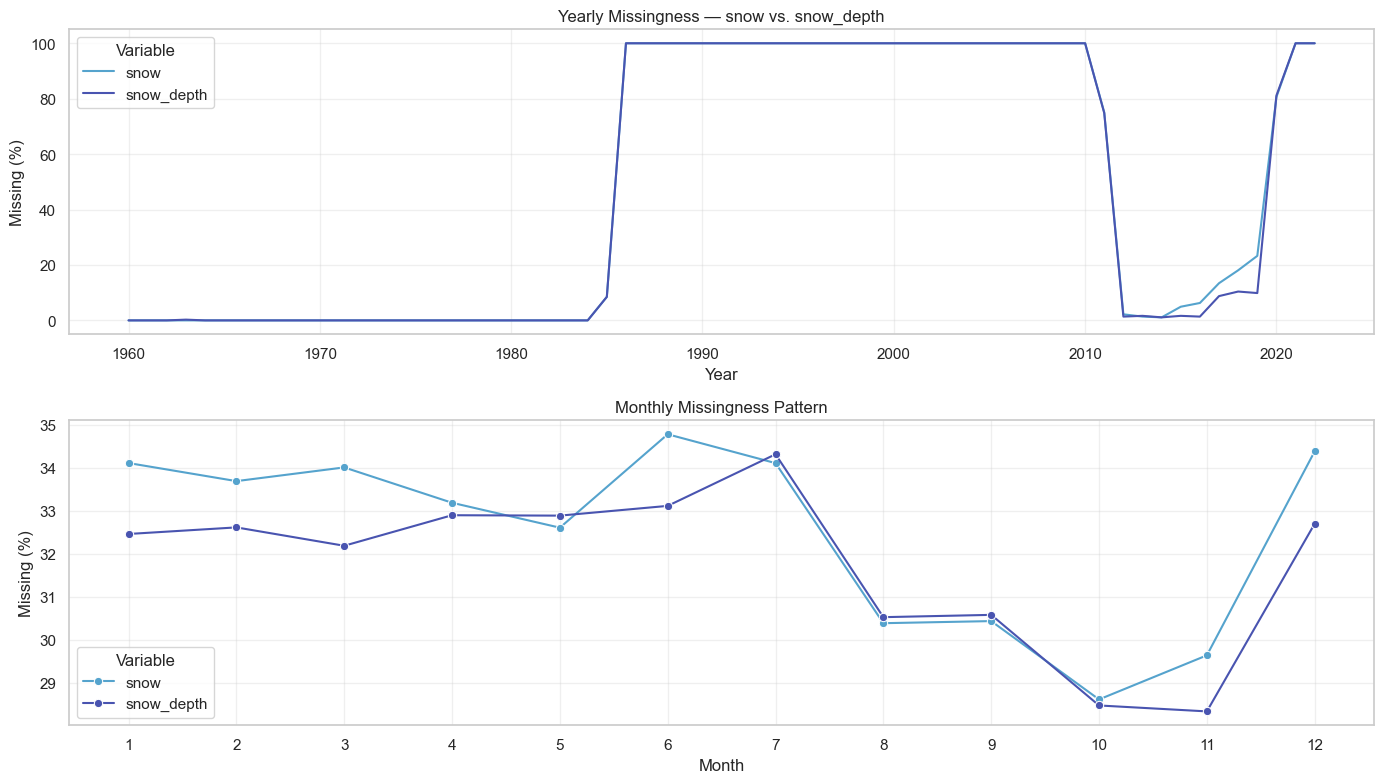

In [11]:
# Ensure DATE index is in datetime format
data.index = pd.to_datetime(data.index)
data = data.sort_index()

# Yearly missing (%)
yearly_snow = (
    data[['snow', 'snow_depth']].isna()
    .groupby(data.index.year).mean().mul(100)
    .reset_index(names='year')
    .melt(id_vars='year', var_name='variable', value_name='missing_pct')
)

# Monthly missing (%)
monthly_snow = (
    data[['snow', 'snow_depth']].isna()
    .groupby(data.index.month).mean().mul(100)
    .reset_index(names='month')
    .melt(id_vars='month', var_name='variable', value_name='missing_pct')
)

# Visualization — vertical layout
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False, sharey=False)

# (1) Yearly pattern
sns.lineplot(data=yearly_snow, x='year', y='missing_pct', hue='variable', ax=axes[0])
axes[0].set_title('Yearly Missingness — snow vs. snow_depth')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Missing (%)')
axes[0].legend(title='Variable')
axes[0].grid(True, alpha=0.3)

# (2) Monthly (seasonal) pattern
sns.lineplot(data=monthly_snow, x='month', y='missing_pct', hue='variable', marker='o', ax=axes[1])
axes[1].set_title('Monthly Missingness Pattern')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Missing (%)')
axes[1].set_xticks(range(1, 13))
axes[1].legend(title='Variable')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### 🧩 Observation — Snow Missingness Patterns

The yearly and monthly missingness plots, together with quick value-counts, point to a consistent pattern:

- Value counts show that both `snow` and `snow_depth` are dominated by 0 values, while NaN accounts for ~32% of records; positive values are rare. This suggests that when snow occurs it is sparsely recorded, and a sizable portion of the series is absent.
- The yearly panel shows that both `snow` and `snow_depth` data were almost completely missing between approximately 1985 and 2010, indicating a long period during which these variables were likely not recorded at all. Before 1985 and after 2010, the missingness was near zero, suggesting that data collection resumed in later years.
- The monthly panel displays a consistent and nearly identical pattern for both variables, certain months contain data while others do not, showing that their availability changes together.

Together, these patterns indicate that the high missingness is the result of systematic non-recording rather than natural seasonal variation. Consequently, **`snow` and `snow_depth` will be removed** from the dataset to ensure consistency and reliability for subsequent temperature–precipitation analysis.

In [12]:
#removed snow and snow depth columns due to sustained high missingness
data = data.drop(columns=['snow', 'snow_depth'], errors='ignore')
data.head(10)

,precipitation,temp_max,temp_min
DATE,,,
1960-01-01,0.00,49.0,30.0
1960-01-02,0.00,49.0,29.0
1960-01-03,0.00,54.0,35.0
1960-01-04,0.00,54.0,36.0
1960-01-05,0.00,55.0,33.0
1960-01-06,0.00,53.0,38.0
1960-01-07,0.00,56.0,46.0
1960-01-08,0.45,54.0,49.0
1960-01-09,0.61,51.0,46.0


With the snow-related variables removed due to high and systematic missingness, the dataset now retains only **precipitation**, **maximum temperature**, and **minimum temperature**. These variables are nearly complete and form the foundation for further exploration. The next step focuses on examining their statistical properties and temporal patterns to better understand overall climate trends.

##### Explore Variables Pattern & Data Imputation

In [13]:
# Unique value count & missing count for each column
summary = pd.DataFrame({
    'unique_values': data.nunique(),
    'missing_count': data.isna().sum(),
    'missing_percent': data.isna().mean() * 100
})
print("Unique value and missing count summary:\n", summary.to_string())

Unique value and missing count summary:
                unique_values  missing_count  missing_percent
precipitation            176            281         1.666766
temp_max                  66              9         0.053384
temp_min                  48             10         0.059315


##### 🧩 Observation — Variables Overview & Imputation Strategy

The dataset includes three core weather features after we removed snow-related variables.

**The overall completeness is excellent**, `temp_max` and `temp_min` have less than 0.1% missing values, while `precipitation` has about 1.7% missing data. The number of unique values also shows sufficient variability, indicating **no obvious encoding or constant-value issues**.

Since temperature is continuous and smoothly varying over time, it can be safely imputed first using time-based interpolation.

In contrast, precipitation exhibits a highly skewed distribution dominated by zeros, and its missing values may represent unrecorded no-rain days or incomplete records. Therefore, a more detailed analysis of its distribution and missingness pattern will be conducted later.

##### Temperature Data Imputation

In [14]:
# Fill small gaps in temperature using time interpolation 
data[['temp_max', 'temp_min']] = ( 
    data[['temp_max', 'temp_min']] .interpolate(method='time', limit_direction='both', 
    limit=3) 
)
print("Missing count for temperatures after interpolation:\n", data[['temp_max', 'temp_min']].isna().sum().rename('missing_count').to_frame().to_string())

Missing count for temperatures after interpolation:
           missing_count
temp_max              0
temp_min              0


All missing temperature values have been successfully filled using time-based interpolation, resulting in a complete dataset for both `temp_max` and `temp_min`.

##### Examination and Imputation of Precipitation

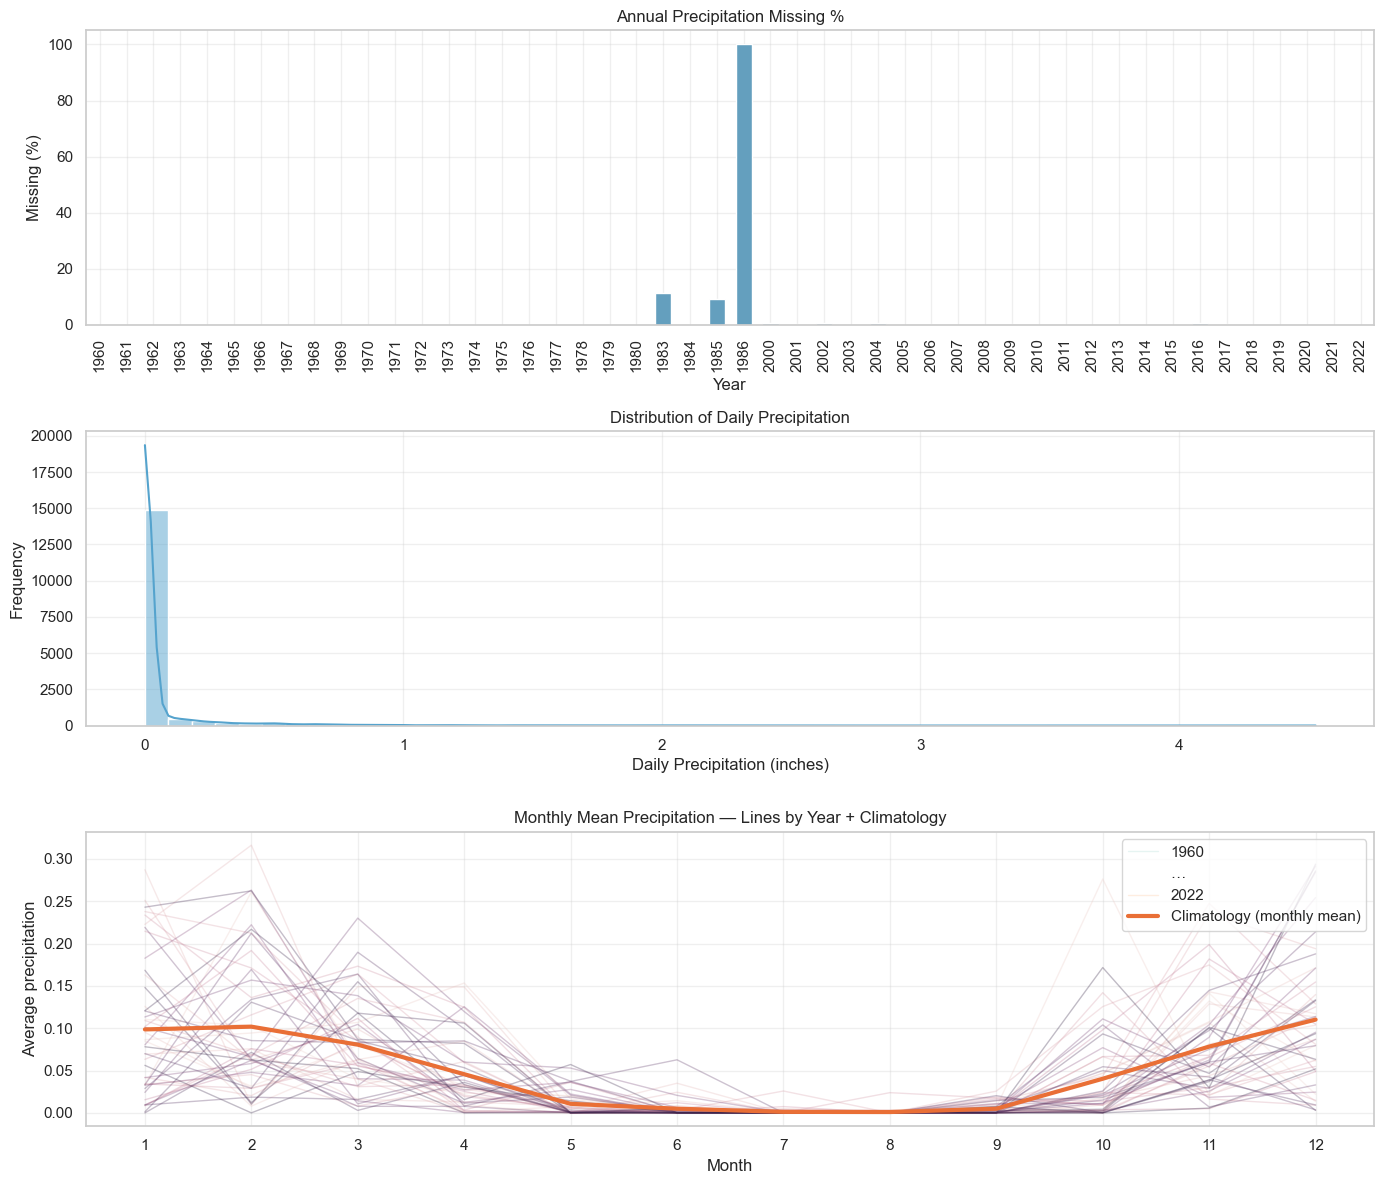

In [15]:
# Visual summary for precipitation imputation analysis
ann_precip  = data['precipitation'].isna().groupby(data.index.year).mean() * 100
monthly_precip_avg = data.groupby(data.index.month)['precipitation'].mean()
precip_year_month = (
    data
    .assign(year=data.index.year, month=data.index.month)
    .groupby(['year','month'])['precipitation'].mean()
    .reset_index()
)

# Adjust number of subplots (now 3)
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1) Annual missing %
sns.barplot(x=ann_precip.index.astype(int), y=ann_precip.values, ax=axes[0], width=0.6)
axes[0].set_title('Annual Precipitation Missing %')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Missing (%)')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True, alpha=0.3)

# 2) Distribution of precipitation 
sns.histplot(data=data, x='precipitation', bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Daily Precipitation')
axes[1].set_xlabel('Daily Precipitation (inches)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# 3) Average monthly precipitation yearly and globally
sns.lineplot(
    data=precip_year_month, x='month', y='precipitation', hue='year',
    estimator=None, units='year', lw=1, alpha=0.30, legend=False, ax=axes[2]
)
axes[2].plot(range(1,13), monthly_precip_avg.values, linewidth=3, label='Climatology (monthly mean)')
axes[2].set_title('Monthly Mean Precipitation — Lines by Year + Climatology')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Average precipitation')
axes[2].set_xticks(range(1,13))
axes[2].grid(True, alpha=0.3)

# Customize legend
years = np.sort(precip_year_month['year'].unique())
color_map_monthly_precip = dict(zip(years, sns.color_palette('icefire', n_colors=len(years))))
first_y, last_y = int(years[0]), int(years[-1])
cl_line = axes[2].lines[-1]
custom_handles = [
    Line2D([0], [0], color=color_map_monthly_precip[first_y], lw=1, alpha=0.30, label=str(first_y)),
    Line2D([0], [0], color='none', lw=0, label='…'),
    Line2D([0], [0], color=color_map_monthly_precip[last_y],  lw=1, alpha=0.30, label=str(last_y)),
    Line2D([0], [0], color=cl_line.get_color(), lw=3, label='Climatology (monthly mean)'),
]
axes[2].legend(handles=custom_handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

In [16]:
dry_ratio = (data['precipitation'] == 0).mean() * 100
print(f"Dry days (precipitation = 0): {dry_ratio:.2f}%")

Dry days (precipitation = 0): 81.05%


##### 🧩 Observation — Precipitation Patterns & Imputation Strategy

- The precipitation data shows an extremely **right-skewed distribution** dominated by zeros, with about **81% dry days**.
- Annual missingness plots reveal that most missing records are concentrated between 1983 and 1985, suggesting **a period of systematic non-recording** rather than random gaps.
- The seasonal profile indicates a clear **wet-winter / dry-summer pattern***, consistent with the regional climate, confirming that most zeros correspond to genuine no-rain days.

Given the structure of the data:

- Short-term or random missing values can be filled using a 1–2 day forward fill, ensuring realistic short-term rainfall continuity.
- Long-term systematic gaps (1983–1985) will be imputed using monthly climatological averages to preserve the typical seasonal variation without overstating rainfall.

In [17]:
# Precipitation Data Imputation
precip = data['precipitation'].copy()

# Systematic gaps
systemic_year_mask = precip.index.year.isin([1983, 1985, 1986])
systemic_missing_mask = systemic_year_mask & precip.isna()

month_index = pd.Series(precip.index.month, index=precip.index)
clim_by_row = month_index.map(monthly_precip_avg)
precip.loc[systemic_missing_mask] = clim_by_row.loc[systemic_missing_mask]

# Random missing values
precip = precip.ffill(limit=2)

data['precipitation'] = precip

print(
    "Missing count for precipitation after imputation:\n",
    data[['precipitation']].isna().sum().rename('missing_count').to_frame().to_string()
)

Missing count for precipitation after imputation:
                missing_count
precipitation              0


All precipitation and temperature gaps have been imputed. The dataset now contains no missing values, we can move on to final data sanity checks and begin exploratory analysis.

##### Data Type & Index sanity check

In [18]:
print(data.dtypes)
print("\nCheck index type:", type(data.index))

precipitation    float64
temp_max         float64
temp_min         float64
dtype: object

Check index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


##### 🧩 Observation — Data Type & Structural Validation

All numerical features, `precipitation`, `temp_max`, and `temp_min`, are stored as float64, and the dataset uses a proper DatetimeIndex.

This confirms that the data is fully structured and ready for time-series analysis, aggregation, and visualization without additional preprocessing.

### 3️⃣ Exploratory Data Analysis

This section explores the key weather variables to understand their distributions, temporal patterns, and relationships with each other. The goal is to identify meaningful features and trends that may influence next-day maximum temperature prediction.

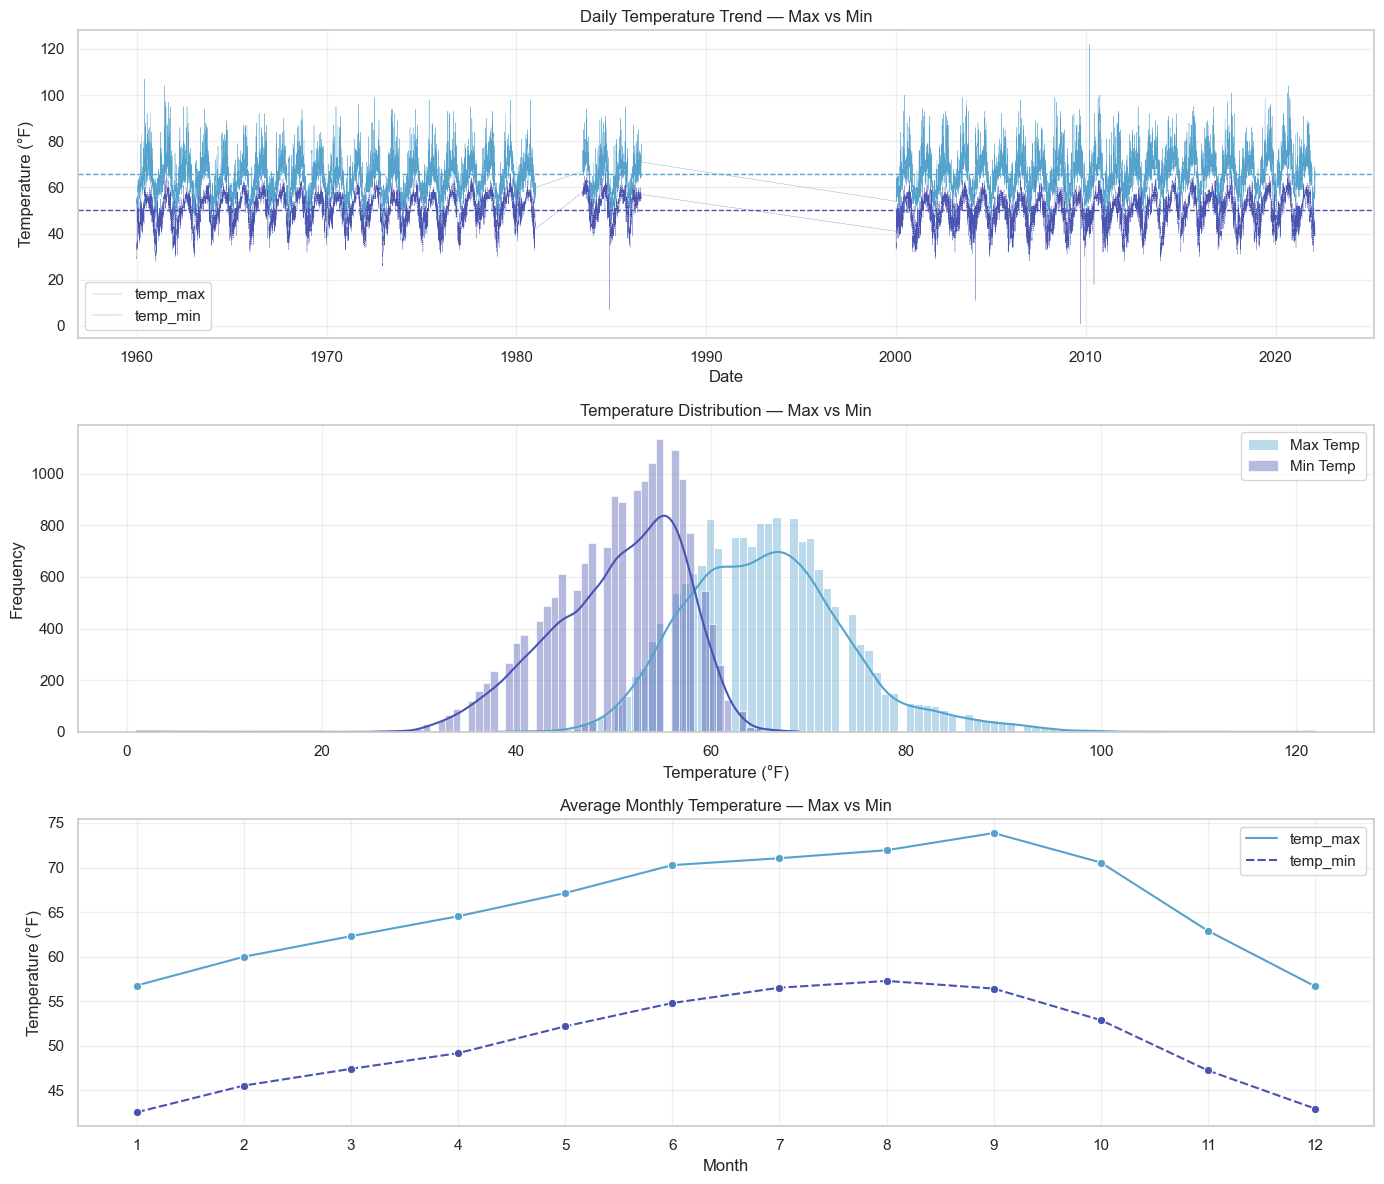

In [19]:
# Visual summary for temperature
temp_monthly = data[['temp_max', 'temp_min']].groupby(data.index.month).mean()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1) Daily Mean Temperature Trend — Max vs Min
ax1 = sns.lineplot(data=data[['temp_max', 'temp_min']], linewidth=0.25, ax=axes[0])

line_colors = dict(zip(['temp_max','temp_min'], [l.get_color() for l in ax1.lines]))
ax1.axhline(data['temp_max'].mean(), color=line_colors['temp_max'], ls='--', lw=1, label='Mean Max Temp')
ax1.axhline(data['temp_min'].mean(), color=line_colors['temp_min'], ls='--', lw=1, label='Mean Min Temp')

ax1.set_title('Daily Temperature Trend — Max vs Min')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°F)')
ax1.grid(True, alpha=0.3)

# 2) Temperature Distribution — Max vs Min (overlaid histograms) 
sns.histplot(data=data, x='temp_max', kde=True, label='Max Temp', alpha=0.4, ax=axes[1])
sns.histplot(data=data, x='temp_min', kde=True, label='Min Temp', alpha=0.4, ax=axes[1])
axes[1].legend()
axes[1].set_title('Temperature Distribution — Max vs Min')
axes[1].set_xlabel('Temperature (°F)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# 3) Average Monthly Temperature — Max vs Min
ax3 = sns.lineplot(data=temp_monthly, ax=axes[2])

for line in ax3.lines:
    line.set_marker('o')

axes[2].set_title('Average Monthly Temperature — Max vs Min')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Temperature (°F)')
axes[2].set_xticks(range(1, 13))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### 🧩 Observation — Temperature Characteristics

The temperature plots reveal clear seasonal and cyclical patterns in both maximum and minimum temperatures, indicating stable yearly seasonality that makes temperature highly predictable using temporal and lagged features.

- The daily trend shows strong annual cycles with occasional gaps corresponding to historical missing data periods.
- The distribution plot indicates an approximately normal shape, with temp_max centered around 70–80°F and temp_min around 60°F, reflecting a typical temperate climate.
- The monthly averages show that temperatures peak in July–September and are lowest in  November–February, confirming expected seasonal variation.

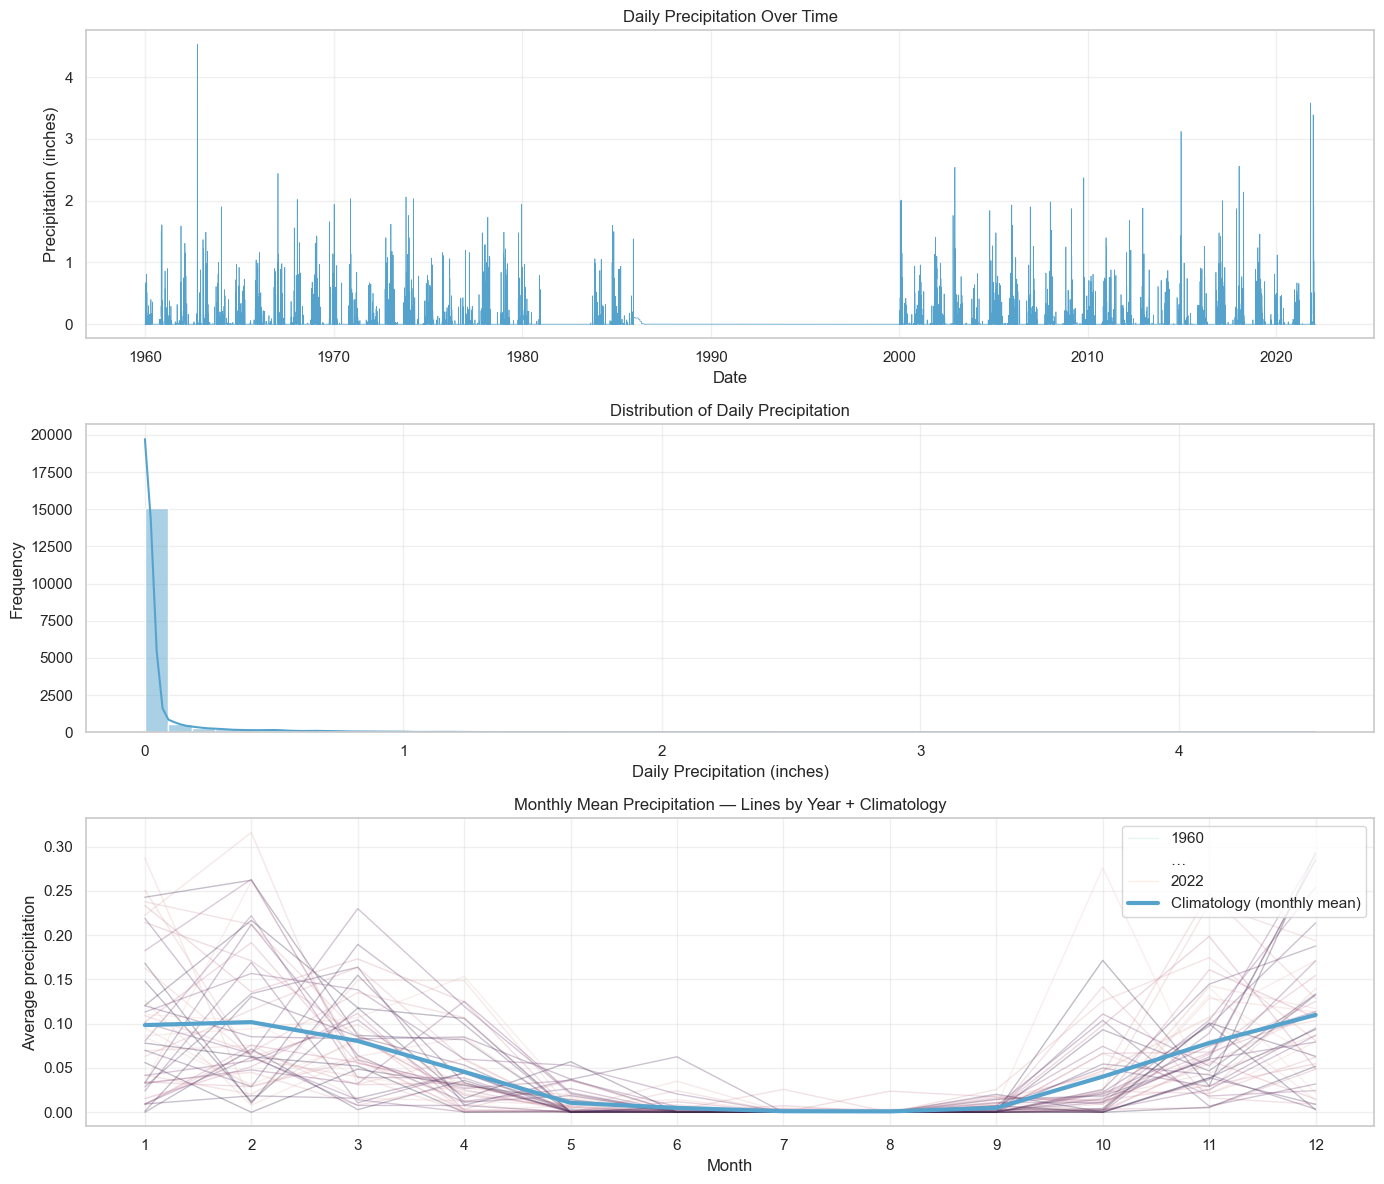

In [20]:
# Visual summary for precipitation
monthly_precip_avg = data.groupby(data.index.month)['precipitation'].mean()
precip_year_month = (
    data
    .assign(year=data.index.year, month=data.index.month)
    .groupby(['year','month'])['precipitation'].mean()
    .reset_index()
)

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1) Daily precipitation over time (replacing the previous annual-missing% plot)
sns.lineplot(x=data.index, y=data['precipitation'], linewidth=0.5, ax=axes[0])
axes[0].set_title("Daily Precipitation Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Precipitation (inches)")
axes[0].grid(True, alpha=0.3)

# 2) Distribution of precipitation 
sns.histplot(data=data, x='precipitation', bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Daily Precipitation')
axes[1].set_xlabel('Daily Precipitation (inches)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# 3) Average monthly precipitation yearly and globally
sns.lineplot(
    data=precip_year_month, x='month', y='precipitation', hue='year',
    estimator=None, units='year', lw=1, alpha=0.30, legend=False, ax=axes[2]
)
axes[2].plot(range(1, 13), monthly_precip_avg.values, linewidth=3, label='Climatology (monthly mean)')
axes[2].set_title('Monthly Mean Precipitation — Lines by Year + Climatology')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Average precipitation')
axes[2].set_xticks(range(1, 13))
axes[2].grid(True, alpha=0.3)

# Customize legend
years = np.sort(precip_year_month['year'].unique())
color_map_monthly_precip = dict(zip(years, sns.color_palette('icefire', n_colors=len(years))))
first_y, last_y = int(years[0]), int(years[-1])
cl_line = axes[2].lines[-1]
custom_handles = [
    Line2D([0], [0], color=color_map_monthly_precip[first_y], lw=1, alpha=0.30, label=str(first_y)),
    Line2D([0], [0], color='none', lw=0, label='…'),
    Line2D([0], [0], color=color_map_monthly_precip[last_y],  lw=1, alpha=0.30, label=str(last_y)),
    Line2D([0], [0], color=cl_line.get_color(), lw=3, label='Climatology (monthly mean)'),
]
axes[2].legend(handles=custom_handles, loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

##### 🧩 Observation — Precipitation Characteristics

The precipitation figures show that rainfall is sporadic and highly skewed, implying it can serve as a binary or threshold-like predictor rather than a continuous variable when modeling next-day temperatures.

- The daily precipitation trend displays irregular rainfall events separated by long dry intervals.
- The distribution confirms that over 80% of days record zero precipitation, with a few extreme events above 2–3 inches.
- The monthly mean precipitation reveals a distinct wet season (winter months) and a dry season (summer months) pattern, consistent across decades.

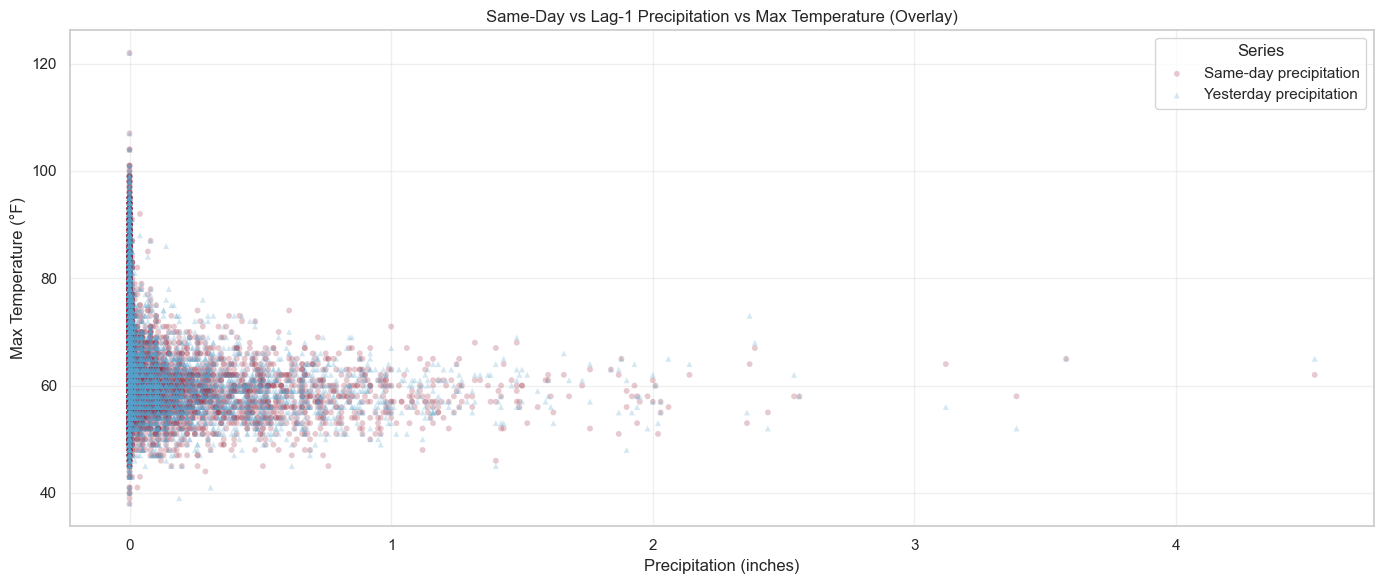

In [21]:
# Feature–Target Relationships
tmp = data.assign(precip_lag1=data['precipitation'].shift(1))

# Pull colors from the *current* seaborn palette and pick two far-apart hues for better contrast
pal = sns.color_palette(n_colors=6)
c_same, c_lag1 = pal[4], pal[0]

fig, ax = plt.subplots(figsize=(14, 6))

# Same-day precipitation vs. max temp
sns.scatterplot(
    data=tmp,
    x='precipitation', y='temp_max',
    alpha=0.25, s=18, edgecolor='none',
    label='Same-day precipitation',
    color=c_same, marker='o', ax=ax
)

# Lag-1 precipitation vs. max temp
sns.scatterplot(
    data=tmp.dropna(subset=['precip_lag1', 'temp_max']),
    x='precip_lag1', y='temp_max',
    alpha=0.25, s=18, edgecolor='none',
    label='Yesterday precipitation',
    color=c_lag1, marker='^', ax=ax
)

ax.set_title('Same-Day vs Lag-1 Precipitation vs Max Temperature (Overlay)')
ax.set_xlabel('Precipitation (inches)')
ax.set_ylabel('Max Temperature (°F)')
ax.grid(True, alpha=0.3)
ax.legend(title='Series')

plt.tight_layout()
plt.show()

##### 🧩 Observation — Precipitation vs. Temperature Relationship

The scatterplots reveal a negative association between precipitation and maximum temperature, suggesting that same-day rainfall is the primary driver of temperature variation, with lagged effects being minimal.

- On days with higher rainfall, `temp_max` tends to be lower, reflecting cooling effects of cloud cover and moisture.
- The lagged relationship shows a similar but weaker pattern. When it rained yesterday, today’s maximum temperature tends to be slightly lower on average, though the effect is notably smaller than that of same-day rainfall.

##### 🔚 Summary of Exploratory Analysis

Overall, the EDA reveals a clear annual temperature cycles and expected seasonal rainfall variation. Temperature values show stable trends without major anomalies, while precipitation is sparse and skewed but plausible. The negative association between rainfall and temperature also looks reasonable. Overall, the data quality and patterns seem suitable for modeling next-day maximum temperature.

### 4️⃣ Model Building

##### Define the Target Variable

To predict tomorrow’s maximum temperature, we align the target by shifting today’s `temp_max` one day back.

In [22]:
data['target'] = data['temp_max'].shift(-1)
data.head()

,precipitation,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16859 entries, 1960-01-01 to 2022-01-28
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  16859 non-null  float64
 1   temp_max       16859 non-null  float64
 2   temp_min       16859 non-null  float64
 3   target         16858 non-null  float64
dtypes: float64(4)
memory usage: 658.6 KB


Since the last entry has no next day observation available, the corresponding target value is NaN. Before proceeding to model training, we’ll remove this final incomplete record to ensure the dataset only includes valid feature–target pairs.

In [24]:
# Remove the last row
data = data.dropna(subset=['target'])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16858 entries, 1960-01-01 to 2022-01-27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  16858 non-null  float64
 1   temp_max       16858 non-null  float64
 2   temp_min       16858 non-null  float64
 3   target         16858 non-null  float64
dtypes: float64(4)
memory usage: 658.5 KB


##### 💡 Model Choice — Ridge Regression

For predicting next-day maximum temperature, Ridge Regression will be used as the baseline model with following explanation:

- It includes **ℓ₂ regularization**, which helps control **multicollinearity** among predictors.  
- It also helps **prevent overfitting** by shrinking large coefficients.  
- Overall, Ridge provides a **stable, interpretable, and well-regularized** baseline model for weather prediction.

Overall, it offers a simple, stable, and interpretable baseline model.

##### Modeling

In [25]:
# Split data
train_set=data.loc[:"2020-12-31"]
test_set=data.loc['2021-01-01':]

X_train = train_set[['precipitation', 'temp_max', 'temp_min']]
y_train = train_set['target']

X_test = test_set[['precipitation', 'temp_max', 'temp_min']]
y_test = test_set['target']

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit Ridge model
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

# Predictions
y_pred = ridge.predict(X_test_scaled)

### 5️⃣ Model Evaluation

In [26]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Ridge Regression Results:")
print(f"Mean Absolute Error (MSAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse):.4f}")
print(f"R² Score: {r2:.4f}")

✅ Ridge Regression Results:
Mean Absolute Error (MSAE): 3.4112
Mean Squared Error (MSE): 20.5588
Root Mean Squared Error (RMSE): 4.5342
R² Score: 0.6544


##### 🧩 Observation — Model Performance

The Ridge Regression model achieves an **R² of 0.65**, indicating that it explains around **65% of the variance** in next-day maximum temperature.  
The **RMSE (~4.53°F)** and **MAE (~3.41°F)** suggest that most predictions are within a few degrees of the actual values, which is reasonable for daily temperature forecasting.  

Overall, the model demonstrates **strong baseline performance** with good generalization and no severe overfitting, validating Ridge as a solid starting point for further feature tuning.


In [27]:
# Evaluation table to compare difference
evaluation_df = pd.DataFrame({
    "target": y_test,
    "predictions": pd.Series(y_pred, index=y_test.index)
})
evaluation_df.columns=["target",'predictions']
evaluation_df.head()

,target,predictions
DATE,,
2021-01-01,57.0,59.810422
2021-01-02,56.0,59.310485
2021-01-03,62.0,58.544162
2021-01-04,59.0,61.523043
2021-01-05,59.0,59.448922


##### Visual Performance Analysis

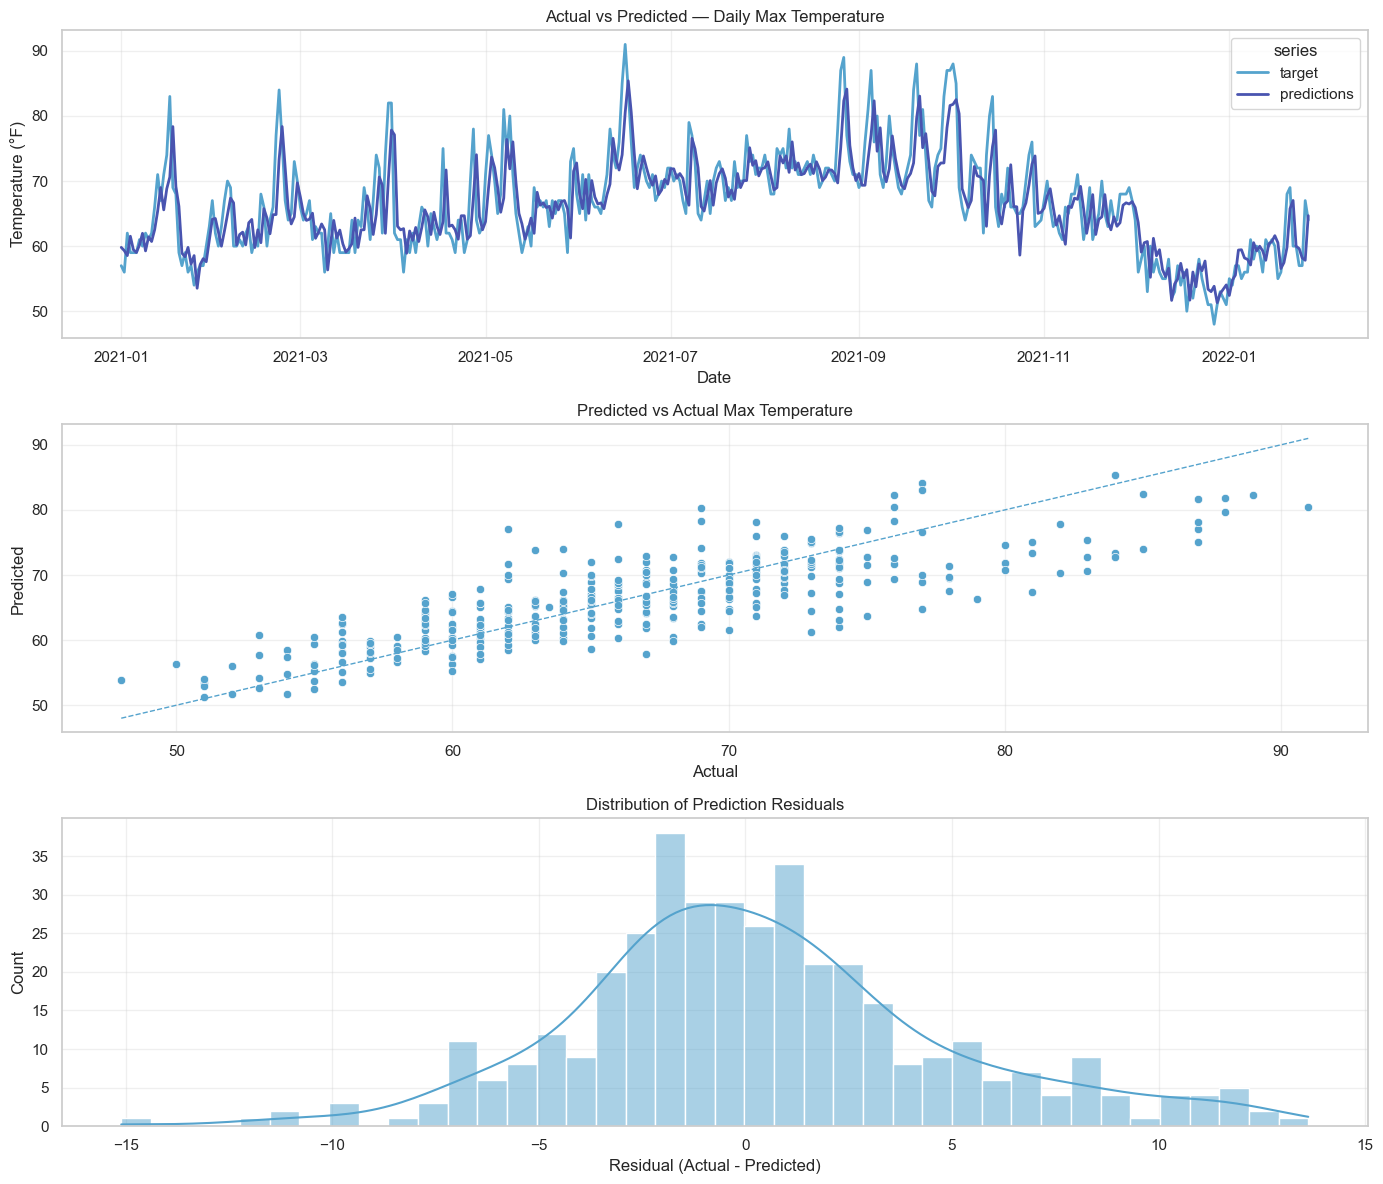

In [28]:
# Evaluation visuals
evaluation_df['residuals'] = evaluation_df['target'] - evaluation_df['predictions']
line_long = (
    evaluation_df[['target', 'predictions']]
    .reset_index()
    .melt(id_vars='DATE', var_name='series', value_name='value')
)

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1) True vs Predicted over time
sns.lineplot(data=line_long, x='DATE', y='value', hue='series', ax=axes[0], linewidth=2)
axes[0].set_title('Actual vs Predicted — Daily Max Temperature')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature (°F)')
axes[0].grid(alpha=0.3)

# 2) Scatter: Predicted vs Actual
sns.scatterplot(data=evaluation_df, x='target', y='predictions', ax=axes[1])
# Ideal 45° reference line
xy_min, xy_max = evaluation_df['target'].min(), evaluation_df['target'].max()
axes[1].plot([xy_min, xy_max], [xy_min, xy_max], linestyle='--', linewidth=1)
axes[1].set_title('Predicted vs Actual Max Temperature')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].grid(alpha=0.3)

# 3) Residual distribution
sns.histplot(evaluation_df['residuals'], bins=40, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Prediction Residuals')
axes[2].set_xlabel('Residual (Actual - Predicted)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##### 🧩 Observation — Visualization

The evaluation plots reveal that the Ridge model performs reasonably well overall:

- The **Actual vs Predicted** line plot shows that predictions generally follow the real temperature trend, capturing both daily and seasonal variations.  
- The **Scatter plot** indicates a strong linear relationship between actual and predicted values, with most points close to the ideal line.  
- The **Residual distribution** is roughly normal and centered near zero, suggesting that errors are balanced without major bias.

However, the model tends to **underestimate extreme temperature peaks** and slightly **over-smooth short-term fluctuations**, reflecting the limitations of a purely linear approach.  

Overall, Ridge Regression provides a solid and interpretable baseline, but more flexible models could further improve accuracy.

##### Interpreting Ridge Model Coefficients

In [29]:
# Coefficients in standardized space
FEATURES = X_train.columns.tolist()
coef_std = ridge.coef_.astype(float)   
b0_std   = ridge.intercept_   

# Convert to original units
mu, sigma = scaler.mean_, scaler.scale_
coef_org  = coef_std / sigma
interc_org = ridge.intercept_ - np.sum(coef_std * (mu / sigma))

# Neat table
coef_df = (
    pd.DataFrame({
        "feature": FEATURES,
        "coef_std": coef_std,
        "coef_orig": coef_org
    })
    .sort_values("coef_orig", ascending=False)
    .reset_index(drop=True)
)

print(f"Intercept (original units): {interc_org:.4f}\n")

print("Coeffeciets:")
display(coef_df)

Intercept (original units): 9.3619

Coeffeciets:


,feature,coef_std,coef_orig
0,temp_max,6.054262,0.720981
1,temp_min,1.214302,0.179740
2,precipitation,-0.409413,-2.243845


##### 🧩 Observation — Ridge Coefficients

The coefficient analysis reveals that:
- **temp_max** has the strongest positive influence on next-day maximum temperature, indicating strong persistence in daily temperature patterns.  
- **temp_min** also contributes positively but with a smaller magnitude, reflecting its secondary role in daily heat retention.  
- **precipitation** shows a negative coefficient, suggesting that rainy days tend to slightly lower the following day’s temperature.  

Overall, these coefficients align with physical expectations: temperature continuity dominates short-term prediction, while rainfall provides a modest cooling effect.


### 6️⃣ Enhancement

##### Prediction Function

In [30]:
def create_predictions(predictors, weather_df, reg):
    """
    Using the specified predictors and a given regressor, fit on data up to
    2020-12-31 and predict from 2021-01-01 onward. 
    Standardization is applied. Returns MAE and an evaluation dataframe.
    """
    # Split data
    train = weather_df.loc[:'2020-12-31']
    test  = weather_df.loc['2021-01-01':]

    X_train, y_train = train[predictors], train['target']
    X_test,  y_test  = test[predictors],  test['target']

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and fit Ridge model
    reg.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = reg.predict(X_test_scaled)

    # Error metric (MAE) and evaluation table
    error = mean_absolute_error(y_test, y_pred)
    evaluation_df = pd.DataFrame({
        "target": y_test, 
        "predictions": pd.Series(y_pred, index=y_test.index)
    })

    return error, evaluation_df

##### Feature Engineering

Before proceeding to modeling improvements, additional weather-derived features can be considered. These engineered features aim to capture longer-term temperature patterns, daily variability, and precipitation effects, all of which can provide the model with richer context for predicting next-day maximum temperature.

In [31]:
# Create a copy for feature engineering
data_feat1 = data.copy()

### Rolling 30-Day Context Features

Rolling 30-day statistics capture the slow-moving climatological background and smooth day-to-day noise, providing a stable context for next-day temperature prediction. Using a 30-day mean (e.g., `month_max`) and its derived deviations/z-scores encodes whether today is unusually warm or cool relative to recent history. This improves signal-to-noise and helps the model learn seasonal level shifts without leaking future information.


In [32]:
# 30-day rolling mean of today's max temperature
data_feat1['temp_max_roll30_mean'] = (
    data_feat1['temp_max']
    .rolling(window=30, min_periods=30)
    .mean()
)

data_feat1

,precipitation,temp_max,temp_min,target,temp_max_roll30_mean
DATE,,,,,
1960-01-01,0.0,49.0,30.0,49.0,NaN
1960-01-02,0.0,49.0,29.0,54.0,NaN
1960-01-03,0.0,54.0,35.0,54.0,NaN
1960-01-04,0.0,54.0,36.0,55.0,NaN
1960-01-05,0.0,55.0,33.0,53.0,NaN
...,...,...,...,...,...
2022-01-23,0.0,60.0,41.0,60.0,56.900000
2022-01-24,0.0,60.0,39.0,57.0,57.066667
2022-01-25,0.0,57.0,43.0,57.0,57.200000


In [33]:
# Relative position of today vs recent month
data_feat1['temp_max_roll30_ratio'] = data_feat1['temp_max'] / data_feat1['temp_max_roll30_mean']

# Daily thermal contrast
data_feat1['temp_max_min_ratio'] = data_feat1['temp_max'] / data_feat1['temp_min']

data_feat1

,precipitation,temp_max,temp_min,target,temp_max_roll30_mean,temp_max_roll30_ratio,temp_max_min_ratio
DATE,,,,,,,
1960-01-01,0.0,49.0,30.0,49.0,NaN,NaN,1.633333
1960-01-02,0.0,49.0,29.0,54.0,NaN,NaN,1.689655
1960-01-03,0.0,54.0,35.0,54.0,NaN,NaN,1.542857
1960-01-04,0.0,54.0,36.0,55.0,NaN,NaN,1.500000
1960-01-05,0.0,55.0,33.0,53.0,NaN,NaN,1.666667
...,...,...,...,...,...,...,...
2022-01-23,0.0,60.0,41.0,60.0,56.900000,1.054482,1.463415
2022-01-24,0.0,60.0,39.0,57.0,57.066667,1.051402,1.538462
2022-01-25,0.0,57.0,43.0,57.0,57.200000,0.996503,1.325581


Three new features were introduced to capture short-term climate dynamics:

- **`temp_max_roll30_mean`** — 30-day rolling average of daily maximum temperature, representing the recent climate baseline.  
- **`temp_max_roll30_ratio`** — ratio of today’s max temperature to the 30-day rolling mean, showing how unusually warm or cool the day is compared to recent conditions.  
- **`temp_max_min_ratio`** — ratio between max and min temperature of the same day, reflecting diurnal temperature variation that often signals clear skies or dry air.

These features can improve the model’s ability to predict next-day maximum temperature by embedding contextual and temporal patterns rather than relying solely on raw daily values.

However, creating rolling windows also generates new missing values at the start of the dataset (where fewer than 30 prior observations exist).  
Before proceeding, we should inspect how many missing entries were introduced and decide on an appropriate handling method.

In [34]:
missing_summary = data_feat1.isna().agg(['sum', 'mean']).T
missing_summary.columns = ['missing_count', 'missing_pct']
missing_summary['missing_pct'] = (missing_summary['missing_pct'] * 100).round(2)
print("Missing value summary after feature creation:\n", missing_summary.to_string())

Missing value summary after feature creation:
                        missing_count  missing_pct
precipitation                    0.0         0.00
temp_max                         0.0         0.00
temp_min                         0.0         0.00
target                           0.0         0.00
temp_max_roll30_mean            29.0         0.17
temp_max_roll30_ratio           29.0         0.17
temp_max_min_ratio               0.0         0.00


##### Handling the Missing Values of New Features

Since the missing values are limited to the first 29 days and structurally caused by rolling computation, a simple row removal is sufficient.

In [35]:
# Drop rows where rolling features are undefined (first 29 days)
data_feat1 = data_feat1.dropna(subset=['temp_max_roll30_mean', 'temp_max_roll30_ratio'])

missing_summary = data_feat1.isna().agg(['sum', 'mean']).T
missing_summary.columns = ['missing_count', 'missing_pct']
missing_summary['missing_pct'] = (missing_summary['missing_pct'] * 100).round(2)
print("Missing value summary after removal:\n", missing_summary.to_string())

Missing value summary after removal:
                        missing_count  missing_pct
precipitation                    0.0          0.0
temp_max                         0.0          0.0
temp_min                         0.0          0.0
target                           0.0          0.0
temp_max_roll30_mean             0.0          0.0
temp_max_roll30_ratio            0.0          0.0
temp_max_min_ratio               0.0          0.0


##### Re-modeling with `create_predictions`

In [36]:
# Defines core features
predictors = ['precipitation', 'temp_max', 'temp_min', 'temp_max_roll30_mean', 'temp_max_roll30_ratio', 'temp_max_min_ratio']

error, evaluation_df = create_predictions(predictors, data_feat1, ridge)

results_df = pd.DataFrame(
    {"Base": [mae], 
    "Roll 30": [error]},
    index=["MAE"]
).applymap(lambda x: f"{x:.4f}")

print("✅ Ridge Regression Results Before & After Feature Engineering:")
display(results_df)

print(f"\n📈 Improvement in MAE: {((mae - error) / mae) * 100:.2f}%")

✅ Ridge Regression Results Before & After Feature Engineering:


,Base,Roll 30
MAE,3.4112,3.3520



📈 Improvement in MAE: 1.74%


##### 🧩 Observation — Model Performance Comparison

The results show a **1.74% improvement** in Ridge Regression performance after introducing engineered features:

- The **Mean Absolute Error (MAE)** decreased slightly, suggesting that the additional rolling and ratio-based predictors helped the model capture short-term trends and relative temperature dynamics.  
- The **`temp_max_roll30_mean`** feature likely improved the model’s understanding of long-term seasonal fluctuations.  
- **Ratio-based features** such as `temp_max_roll30_ratio` and `temp_max_min_ratio` added meaningful scale-normalized information, helping the model generalize better to varying temperature ranges.  

Overall, the **feature-engineered Ridge model** demonstrates enhanced predictive accuracy and improved interpretability, validating the value of incorporating temporal and relative features in weather forecasting tasks.

##### Further Enhancing with Climatological Features

To enhance the model’s understanding of long-term seasonal patterns, we introduce **monthly** and **day-of-year climatological averages** for maximum temperature.  

These features provide the model with a baseline expectation of seasonal temperature cycles, helping it distinguish short-term fluctuations from recurring climatic trends.  

In [37]:
# Copy dataset to avoid overwriting
data_feat2 = data_feat1.copy()

# Monthly climatological averages (mean TMAX by month)
monthly_climate = data_feat2.groupby(data_feat2.index.month)["temp_max"].mean()
data_feat2["month"] = data_feat2.index.month
data_feat2["temp_max_month_avg"] = data_feat2["month"].map(monthly_climate)

# Day-of-year climatological averages (mean TMAX by DOY)
doy_climate = data_feat2.groupby(data_feat2.index.dayofyear)["temp_max"].mean()
data_feat2["doy"] = data_feat2.index.dayofyear
data_feat2["temp_max_day_avg"] = data_feat2["doy"].map(doy_climate)

# Clean helper columns
data_feat2 = data_feat2.drop(columns=["month", "doy"]) 

data_feat2.head()

,precipitation,temp_max,temp_min,target,temp_max_roll30_mean,temp_max_roll30_ratio,temp_max_min_ratio,temp_max_month_avg,temp_max_day_avg
DATE,,,,,,,,,
1960-01-30,0.00,61.0,49.0,59.0,55.233333,1.104406,1.244898,56.794242,57.630435
1960-01-31,0.00,59.0,46.0,62.0,55.566667,1.061788,1.282609,56.794242,57.739130
1960-02-01,0.81,62.0,51.0,59.0,56.000000,1.107143,1.215686,59.986154,58.673913
1960-02-02,0.00,59.0,43.0,59.0,56.166667,1.050445,1.372093,59.986154,59.195652
1960-02-03,0.20,59.0,47.0,60.0,56.333333,1.047337,1.255319,59.986154,59.152174


In [38]:
missing_summary2 = data_feat2.isna().agg(['sum', 'mean']).T
missing_summary2.columns = ['missing_count', 'missing_pct']
missing_summary2['missing_pct'] = (missing_summary2['missing_pct'] * 100).round(2)

print("🧭 Missing value summary after seasonal feature integration:\n")
print(missing_summary2.to_string())

🧭 Missing value summary after seasonal feature integration:

                       missing_count  missing_pct
precipitation                    0.0          0.0
temp_max                         0.0          0.0
temp_min                         0.0          0.0
target                           0.0          0.0
temp_max_roll30_mean             0.0          0.0
temp_max_roll30_ratio            0.0          0.0
temp_max_min_ratio               0.0          0.0
temp_max_month_avg               0.0          0.0
temp_max_day_avg                 0.0          0.0


In [39]:
# Combine all predictors
predictors = [
    "precipitation",
    "temp_max",
    "temp_min",
    # Roll 30
    "temp_max_roll30_mean",
    "temp_max_roll30_ratio",
    "temp_max_min_ratio",
    # Climatology
    "temp_max_month_avg",
    "temp_max_day_avg",
]

# Model training & evaluation
error_2, eval_2 = create_predictions(predictors, data_feat2, ridge)

# Compare with the previous baseline model
results_df = pd.DataFrame(
    {"Base": [mae], "Roll 30": [error], "Climatology": [error_2]},
    index=["MAE"]
).applymap(lambda x: f"{x:.4f}")

print("✅ Ridge Regression Comparison:")
display(results_df)

print("\n📈 MAE Improvement:")
print(f"Improvement vs Baseline (%): {(mae - error_2) / mae * 100:.2f}%")
print(f"Improvement vs Roll-30 (%): {(error - error_2) / error * 100:.2f}%")

✅ Ridge Regression Comparison:


,Base,Roll 30,Climatology
MAE,3.4112,3.3520,3.3076



📈 MAE Improvement:
Improvement vs Baseline (%): 3.04%
Improvement vs Roll-30 (%): 1.33%


##### 🧩 Observation — Impact of Climatology Features

The integration of climatological averages produced a **clear performance improvement** compared to both the baseline and the rolling-window models:

- The **monthly average (`temp_max_month_avg`)** feature helps the model capture **broader seasonal cycles**, for example, systematically warmer summer months or cooler winter months.  
- The **day-of-year average (`temp_max_day_avg`)** fine-tunes this effect, allowing the model to follow **within-season variations**.  

Compared with the **Roll-30 model**, this approach embeds historical climatology without introducing high short-term noise, thus improving generalization on unseen periods.

##### Interaction & Ratio Features

- **`temp_diff_prev` (Day-to-day change in TMAX)**  
  Captures short-term **momentum** in temperature. If yesterday was warmer than the day before, tomorrow is more likely to stay elevated (and vice versa). This helps the model learn **trend direction** rather than relying only on absolute levels.

- **`precip_temp_min_ratio` (Precipitation scaled by daily TMIN)**  
  Encodes the **moisture–cooling interaction**: precipitation events—especially on cooler nights—often suppress next-day highs. Normalizing by `temp_min` adds context about the thermal environment, making the effect more comparable across seasons.

- **`temp_avg_ratio` ((TMAX+TMIN) relative to 30-day mean)**  
  Provides a **seasonally-aware baseline** by indicating whether the current day is warm or cool **relative to recent climate**. This improves generalization across seasons and reduces bias when absolute temperatures shift with the time of year.

These features combine **trend**, **weather interaction**, and **seasonal context**, giving a richer signals to produce more physically consistent forecasts.

In [40]:
# Copy previous climatology dataset
data_feat3 = data_feat2.copy()

data_feat3["temp_max_diff_prev"] = data_feat3["temp_max"].diff(1).fillna(0.0)
data_feat3["precip_temp_min_ratio"] = data_feat3["precipitation"] / (data_feat3["temp_min"])
data_feat3["temp_avg_ratio"] = (data_feat3["temp_max"] + data_feat3["temp_min"]) / (
    2 * data_feat3["temp_max_roll30_mean"]
)

data_feat3

,precipitation,temp_max,temp_min,target,temp_max_roll30_mean,temp_max_roll30_ratio,temp_max_min_ratio,temp_max_month_avg,temp_max_day_avg,temp_max_diff_prev,precip_temp_min_ratio,temp_avg_ratio
DATE,,,,,,,,,,,,
1960-01-30,0.00,61.0,49.0,59.0,55.233333,1.104406,1.244898,56.794242,57.630435,0.0,0.000000,0.995775
1960-01-31,0.00,59.0,46.0,62.0,55.566667,1.061788,1.282609,56.794242,57.739130,-2.0,0.000000,0.944811
1960-02-01,0.81,62.0,51.0,59.0,56.000000,1.107143,1.215686,59.986154,58.673913,3.0,0.015882,1.008929
1960-02-02,0.00,59.0,43.0,59.0,56.166667,1.050445,1.372093,59.986154,59.195652,-3.0,0.000000,0.908012
1960-02-03,0.20,59.0,47.0,60.0,56.333333,1.047337,1.255319,59.986154,59.152174,0.0,0.004255,0.940828
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-23,0.00,60.0,41.0,60.0,56.900000,1.054482,1.463415,56.794242,57.130435,-9.0,0.000000,0.887522
2022-01-24,0.00,60.0,39.0,57.0,57.066667,1.051402,1.538462,56.794242,57.239130,0.0,0.000000,0.867407
2022-01-25,0.00,57.0,43.0,57.0,57.200000,0.996503,1.325581,56.794242,57.347826,-3.0,0.000000,0.874126


In [41]:
missing_summary3 = data_feat3.isna().agg(['sum', 'mean']).T
missing_summary3.columns = ['missing_count', 'missing_pct']
missing_summary3['missing_pct'] = (missing_summary3['missing_pct'] * 100).round(2)

print("🧭 Missing value summary after seasonal feature integration:\n")
print(missing_summary3.to_string())

🧭 Missing value summary after seasonal feature integration:

                       missing_count  missing_pct
precipitation                    0.0          0.0
temp_max                         0.0          0.0
temp_min                         0.0          0.0
target                           0.0          0.0
temp_max_roll30_mean             0.0          0.0
temp_max_roll30_ratio            0.0          0.0
temp_max_min_ratio               0.0          0.0
temp_max_month_avg               0.0          0.0
temp_max_day_avg                 0.0          0.0
temp_max_diff_prev               0.0          0.0
precip_temp_min_ratio            0.0          0.0
temp_avg_ratio                   0.0          0.0


In [42]:
predictors = [
    "precipitation",
    "temp_max",
    "temp_min",
    "temp_max_roll30_mean",
    "temp_max_roll30_ratio",
    "temp_max_min_ratio",
    "temp_max_month_avg",
    "temp_max_day_avg",
    # New interaction & ratio features
    "temp_max_diff_prev",
    "precip_temp_min_ratio",
    "temp_avg_ratio",
]

# Train & evaluate
error_3, eval_3 = create_predictions(predictors, data_feat3, ridge)

# Results
results_df = pd.DataFrame(
    {"Base": [mae], "Roll 30": [error], "Climatology": [error_2], "Interaction": [error_3]},
    index=["MAE"]
).applymap(lambda x: f"{x:.4f}")

print("✅ Ridge Regression Comparison:")
display(results_df)

# Improvement summary
print("\n📈 MAE Improvement (%):")
print(f"vs Base: {(mae - error_3) / mae * 100:.2f}%")
print(f"vs Roll-30: {(error - error_3) / error * 100:.2f}%")
print(f"vs Climatology: {(error_2 - error_3) / error_2 * 100:.2f}%")

✅ Ridge Regression Comparison:


,Base,Roll 30,Climatology,Interaction
MAE,3.4112,3.3520,3.3076,3.2866



📈 MAE Improvement (%):
vs Base: 3.65%
vs Roll-30: 1.95%
vs Climatology: 0.63%


##### 🧩 Observation — Impact of Interaction & Ratio Feature

The **Interaction & Ratio** feature version of the Ridge Regression model achieved a better overall accuracy, with a **3.65 % reduction in MAE** compared to the original baseline.

Although the absolute improvement over the climatology model (≈ 0.63 %) is modest, it demonstrates that these engineered variables add complementary signals that enhance physical realism and predictive stability.  

##### Tuning Ridge with Time-Series Cross-Validation

The current Ridge model uses standardized linear features and a fixed regularization strength (α). While effective for preventing overfitting, a single α may not capture the best bias–variance balance, and a purely linear form can miss subtle nonlinear patterns between weather variables.

To enhance performance while respecting the **temporal structure** of the data, we tune the Ridge model as follows:

- Use **time-series cross-validation** (`TimeSeriesSplit`) within `RidgeCV` to search multiple α values across a logarithmic scale, ensuring that model evaluation follows chronological order and avoids data leakage from future observations.  
- Add **polynomial and interaction terms** to enable Ridge to capture nonlinear relationships, such as how temperature and precipitation jointly influence the next day’s maximum temperature.

In [43]:
# Construct RidgeCV pipline
ridge_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", RidgeCV(alphas=np.logspace(-2, 3, 20), cv=TimeSeriesSplit(n_splits=5)))
])

# Train & Prediction
mae_cv, eval_cv = create_predictions(predictors, data_feat3, ridge_cv)

# Result
best_alpha = ridge_cv.named_steps["ridge"].alpha_

results_df = pd.DataFrame(
    {
        "Base": [mae],
        "Roll 30": [error],
        "Climatology": [error_2],
        "Interaction": [error_3],
        "RidgeCV": [mae_cv]
    },
    index=["MAE"]
).applymap(lambda x: f"{x:.4f}")

print(f"\n🔎 Best alpha selected by CV: {best_alpha:.4f}\n")

print("✅ Ridge Regression Comparison (Including RidgeCV with TimeSeriesSplit):")
display(results_df)

print("\n📈 MAE Improvement (%):")
print(f"vs Base: {(mae - mae_cv) / mae * 100:.2f}%")
print(f"vs Roll-30: {(error - mae_cv) / error * 100:.2f}%")
print(f"vs Climatology: {(error_2 - mae_cv) / error_2 * 100:.2f}%")
print(f"vs Interaction: {(error_3 - mae_cv) / error_3 * 100:.2f}%")


🔎 Best alpha selected by CV: 1000.0000

✅ Ridge Regression Comparison (Including RidgeCV with TimeSeriesSplit):


,Base,Roll 30,Climatology,Interaction,RidgeCV
MAE,3.4112,3.3520,3.3076,3.2866,3.2621



📈 MAE Improvement (%):
vs Base: 4.37%
vs Roll-30: 2.68%
vs Climatology: 1.38%
vs Interaction: 0.75%


##### 🧩 Observation — Final RidgeCV Model Performance

The Ridge model tuned with **time-series cross-validation (5 folds)** and **polynomial feature expansion** achieved the lowest MAE among all tested models.  

The best regularization strength was **α = 1000**, balancing model flexibility and stability.

Compared to the base linear Ridge model, the tuned version reduced the MAE by **≈4.37%**, demonstrating that incorporating both nonlinear interactions and proper temporal validation helps the model generalize better to unseen periods.

##### Save Model

In [54]:
joblib.dump(ridge_cv, "ridgecv_timeseries_model.joblib") 

['ridgecv_timeseries_model.joblib']

### 7️⃣ Conclusion

This project developed an end-to-end weather prediction pipeline for forecasting the next day’s maximum temperature.  

We explored several Ridge-based regression approaches and progressively improved model accuracy.

The final model, **RidgeCV with polynomial feature expansion and time-series cross-validation (5 folds)**, achieved the lowest MAE of **3.2621°F**, improving by **≈4.37%** compared to the baseline Ridge model.  
This tuning strategy effectively balanced bias and variance, capturing mild nonlinear relationships while preserving model interpretability.